### Ch6.1 매개변수 갱신
- 최적화(Optimization) : 신경망 학습 시 손실 함수의 값을 가능한 낮추는 매개변수의 최적값을 찾는 것
- 매개변수 공간은 매우 넓고 복잡한 만큼 최적의 솔류션을 쉽게 찾을 수 없음
- 현재까지는 매개변수의 기울기(미분)를 구해 기울어진 방향으로 매개변수 값을 갱신하는 SGD를 이용하였음

#### 확률적 경사 하강법(SGD, Stochastic Gradient Descent)의 단점
1. 단순하고 구현이 쉽지만 문제에 따라 비효율적일 때가 있음
2. 무작정 기울어진 방향으로 진행하는 단순한 방식을 갖은 SGD는 방향에 따라 성질이 다른 비등방성(anisotropy)함수에서는 탐색 경로가 비효율적임

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### 모멘텀(Momentum)
- SGD를 대체하는 기법 중 하나로, 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타냄
- 따라서, 모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직임

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None   # v는 물체의 속도
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

#### AdaGrad
- 학습률을 서서히 낮추는 방법에서 발전시킨 방법으로, 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행함

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### Adam
- 공이 그릇 바닥을 구르는 듯한 움직임을 보이는 모멘텀과 매개변수의 원소마다 적응적으로 갱신 정도를 조정하는 AdaGrad를 융합한 방법
- 하이퍼파라미터의 '편향 보정'이 진행됨

In [4]:
### Adam은 하이퍼파라미터 3개를 지정(학습률, 1차 모멘텀용 계수, 2차 모멘턴용 계수)
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### Ch6.2 가중치의 초깃값
- 가중치의 초깃값은 신경망 학습에서 중요한 부분으로 무엇으로 설정하느냐에 따라 학습의 성패가 가려짐
- 은닉층의 활성화값*활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있음
- 따라서, 가중치의 초깃값에 따라 은닞층 활성화값들이 어떻게 변화하는지 간단한 실험을 진행

1. 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 충의 활성화값 분포를 확인

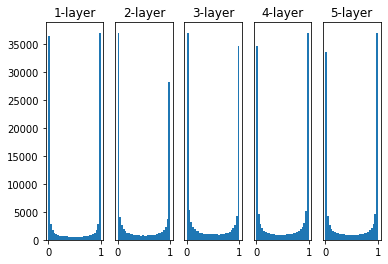

In [6]:
### 가중치의 표준편차가 1인 정규분포인 경우
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
input_data = np.random.randn(1000, 100)  ### 1000개의 데이터
node_num = 100  ### 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  ### 은닉층이 5개
activations = {}  ### 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

### 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 각 층의 활성확밧들이 0과 1에 치우쳐 분포된 것을 확인할 수 있음
- 시그모이드 함수는 출력이 0이나 1에 가까워지자 그 미분은 0에 다가가기 때문에 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라지는 현상이 발생할 수 있으며, 이 문제는 기울기 소실(gradient vanishing)이라고 함

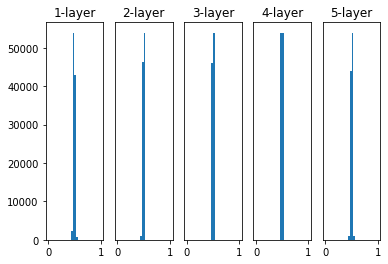

In [7]:
### 가중치의 표준편차가 0.01인 정규분포인 경우
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

### 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 데이터의 분포가 0.5 부근에 집중되어 있음
- 해당 경우는 다수의 뉴런이 거의 같은 값을 출력하고 있기 때문에 뉴련을 여러 개 둔 의미가 사라진다고 할 수 있음
- 따라서, 활성화값들이 한쪽으로 치우치면 표현력을 제한한다는 관점에서 문제가 발생됨

2. Xavier 초깃값 사용

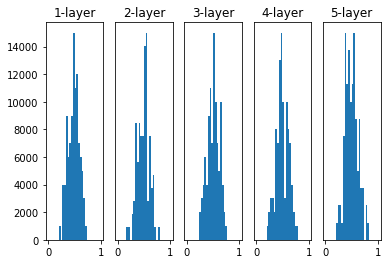

In [8]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

### 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 층이 깊어지면서 형태가 다소 일그러지만 앞선 방식보다는 확실히 넓게 분포됨을 알 수 있어 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대됨

### 배치 정규화(Batch Normalization)
- 배치 정규화는 각층의 활성화값 분포가 적당히 퍼지도록 강제한다는 아이디어에서 출발한 방법임
- 배치 정규화는 다음과 같은 장점이 있음
1. 학습을 빨리 진행할 수 있음
2. 초깃값에 크게 의존하지 않음
3. 오버피팅을 억제함 => 드롭아웃 등의 필요성 감소

### 오버피팅(Overfitting)
- 오버피팅은 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 뜻함
- 오버피팅은 다음과 같은 경우에서 주로 일어남
1. 매개변수가 많고 표현력이 높은 모델
2. 훈력 데이터가 적은 경우

#### 가중치 감소(weight decay)
- 오버피팅을 억제하기 위해 가중치 감소(weight decay)를 이용함
- 가중치 감소는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법

#### 드롭아웃(Dropout)
- 오버피팅을 억제하기 위해 추가적으로 사용하는 방법으로 드롭아웃이 있음
- 드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법

In [9]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

#### 앙상블 학습(Ensemble learning)
- 앙상블 학습은 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식으로 드롭아웃과 밀접한 관련이 있음
- 드롭아웃이 학습 시 뉴런을 무작위로 삭제하는 행위 = 앙상블 학습에서 매번 다른 모델을 학습시키는 행위
- 드롭아웃이 학습 시 뉴런의 출력을 삭제한 비율 = 앙상블 학습에서 여러 모델의 평균을 내는 것

### 하이퍼파리미터 최적화
- 하이퍼파라미터에는 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습룰과 가중치 감소 등이 있음
- 하이퍼파라미터으 값을 적절하게 설정하지 않으면 모델의 성능이 떨어지지는 경우가 많아, 그 값을 결정하기까지 일반적으로 많은 시행착오를 겪음

#### 검증 데이터(Validation data)
- 검증 데이터는 하이퍼파라미터의 적절성을 평가하는 데이터라고 할 수 있음
- 따라서, 훈련 데이터는 매개변수(가중치와 편향)의 학습에 이용하고, 검증 데이터는 하이퍼파라미터의 성능을 평가하는데, 시험 데이터는 범용 성능을 확인하기 이용

In [10]:
import numpy as np
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

- 하이퍼파라미터 최적화의 핵심은 하이퍼파라미터의 '최적 값;이 존재하는 범위를 조금씩 줄여나가는 것
- 또한, 그리드 서치(grid search)와 같은 규치적인 탐색보다는 무작위 샘플링을 통해 탐색하는 편이 좋은 결과를 나타낸다고 알려져 있음
- 베이즈 최적화(Bayesian optimization)는 베이즈 정리를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행함